# `MEDUSA`

### Setup and definitions

First, we set up a database with temporally distributed exchanges.

In [1]:
from notebooks.example_databases import *
db_test_dynamic_biosphere()

100%|██████████| 1/1 [00:00<00:00, 12052.60it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<00:00, 48770.98it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<00:00, 52428.80it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<00:00, 49932.19it/s]

Vacuuming database 


The point of `Medusa` is to choose processes from different background databases depending on the timing of a process. To do so, we need to know which database represents what time:

In [2]:
from datetime import datetime

database_date_dict = {
    "background_2008": datetime.strptime("2008", "%Y"),
    "background_2024": datetime.strptime("2024", "%Y"),
    "foreground": "dynamic",  # flag databases that should be temporally distributed with "dynamic"
}

Also, we can define at what point the underlying graph traversal should stop traversing the supply chain graph, i.e. where we don't expect any more significant temporal distributions or scores. We do this with a filter-function. For now, we just tell it to diregard all nodes in the background databases:

Lastly, we of course need to define our demand (functional unit) and impact assessment method:

In [3]:
demand = {('foreground', 'A'): 1}
method = ('GWP', 'example')

### MedusaLCA calculation

Now we can create our `MedusaLCA`. On creation, it automatically calculates a static LCA of the system, starts the graph traversal and stores the temporal information internally.

In [4]:
from timex_lca import MedusaLCA
mlca = MedusaLCA(demand, method, None, database_date_dict)

Calculation count: 2


Now, we can build the timeline of exchanges between processes. Note how in addition to the orignal database ids, we now have "time mapped" ids for all consumers and producers, repesenting the time-specific version of the processes.

In [5]:
import warnings
warnings.filterwarnings("ignore")
mlca.build_timeline()

,hash_producer,time_mapped_producer,date_producer,producer,producer_name,hash_consumer,time_mapped_consumer,date_consumer,consumer,consumer_name,amount,interpolation_weights
0,2018,8,2018-01-01,2,C,2023,9,2023-01-01,6,B,13.0,"{'background_2008': 0.37491444216290215, 'back..."
1,2023,9,2023-01-01,6,B,2024,10,2024-01-01,7,A,4.0,"{'background_2008': 0.06245722108145102, 'back..."
2,2024,10,2024-01-01,7,A,2024,-1,2024-01-01,-1,-1,1.0,{'background_2024': 1}


Next, we tell the MedusaLCA to build the datapackage including the matrix modifications, adding the time-specific version of processes, including the new technosphere and biosphere exchanges.

In [6]:
mlca.build_datapackage()

In [7]:
mlca.lci()
mlca.lcia()


{'name': 'C', 'location': 'somewhere', 'reference product': 'c', 'database': 'background_2024', 'code': 'C', 'id': 2}
{'name': 'C', 'location': 'somewhere', 'reference product': 'c', 'database': 'background_2024', 'code': 'C', 'id': 2}
{'name': 'C', 'location': 'somewhere', 'reference product': 'c', 'database': 'background_2024', 'code': 'C', 'id': 2}

{'name': 'Electricity production, wind', 'location': 'somewhere', 'reference product': 'electricity, wind', 'database': 'background_2024', 'code': 'electricity_wind', 'id': 3}

{'name': 'C', 'location': 'somewhere', 'reference product': 'c', 'database': 'background_2008', 'code': 'C', 'id': 4}
{'name': 'C', 'location': 'somewhere', 'reference product': 'c', 'database': 'background_2008', 'code': 'C', 'id': 4}
{'name': 'C', 'location': 'somewhere', 'reference product': 'c', 'database': 'background_2008', 'code': 'C', 'id': 4}

{'name': 'Electricity production, wind', 'location': 'somewhere', 'reference product': 'electricity, wind', 'dat

In [9]:
mlca.node_id_collection_dict['first_level_background_node_ids_all']

{2, 4}

Let's compare the results of the static LCA and the MedusaLCA:

In [10]:
database_date_dict

{'background_2008': datetime.datetime(2008, 1, 1, 0, 0),
 'background_2024': datetime.datetime(2024, 1, 1, 0, 0),
 'foreground': 'dynamic'}

In [11]:
print('Old static LCA Score:', mlca.static_lca.score)
print('New MEDUSA LCA Score:', mlca.score)

Old static LCA Score: 46176.0
New MEDUSA LCA Score: 44011.99383983573


In [12]:
mlca.create_labelled_technosphere_dataframe()

,"((background_2024, C), 2024)","((background_2024, electricity_wind), 2024)","((background_2008, C), 2008)","((background_2008, electricity_wind), 2008)","((foreground, B), dynamic)","((foreground, A), dynamic)","((background_2024, C), 2018)","((foreground, B), 2023)","((foreground, A), 2024)"
"((background_2024, C), 2024)",1.0,0.0,0.0,0.0,-13.0,0.0,-0.625086,0.0,0.0
"((background_2024, electricity_wind), 2024)",-1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
"((background_2008, C), 2008)",0.0,0.0,1.0,0.0,0.0,0.0,-0.374914,0.0,0.0
"((background_2008, electricity_wind), 2008)",0.0,0.0,-1.0,1.0,0.0,0.0,0.000000,0.0,0.0
"((foreground, B), dynamic)",0.0,0.0,0.0,0.0,1.0,-4.0,0.000000,0.0,0.0
"((foreground, A), dynamic)",0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0
"((background_2024, C), 2018)",0.0,0.0,0.0,0.0,0.0,0.0,1.000000,-13.0,0.0
"((foreground, B), 2023)",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,-4.0
"((foreground, A), 2024)",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0


In [13]:
mlca.create_labelled_biosphere_dataframe()

,"((background_2024, C), 2024)","((background_2024, electricity_wind), 2024)","((background_2008, C), 2008)","((background_2008, electricity_wind), 2008)","((foreground, B), dynamic)","((foreground, A), dynamic)","((background_2024, C), 2018)","((foreground, B), 2023)","((foreground, A), 2024)"
"(temporalis-bio, CO2)",0.0,888.0,0.0,777.0,0.0,0.0,0.0,0.0,0.0


In [14]:
mlca.supply_array

array([ 0.,  0.,  0.,  0.,  0.,  0., 52.,  4.,  1.])

In [15]:
df = mlca.create_labelled_dynamic_biosphere_dataframe()
df

,"((background_2024, C), 2024)","((background_2024, electricity_wind), 2024)","((background_2008, C), 2008)","((background_2008, electricity_wind), 2008)","((foreground, B), dynamic)","((foreground, A), dynamic)","((background_2024, C), 2018)","((foreground, B), 2023)","((foreground, A), 2024)"
"(CO2, 2024-01-01T00:00:00)",888.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(CO2, 2008-01-01T00:00:00)",0.0,0.0,777.0,0.0,0.0,0.0,0.0,0.0,0.0
"(CO2, 2018-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,888.0,0.0,0.0


In [16]:
mlca.characterize_dynamic_lci(type="GWP")

,date,amount,flow,flow_name,activity,activity_name,amount_sum
0,2018-01-01,46176.0,1,carbon dioxide,8,"(background_2024, C)",46176.0


In [17]:
mlca.static_lca.score

46176.0

In [18]:
mlca.characterized_dynamic_score

46176.0

In [19]:
mlca.dynamic_inventory['CO2']['amount'].sum()

46176.0

In [ ]:
538.7036631231679
897.1609563471802

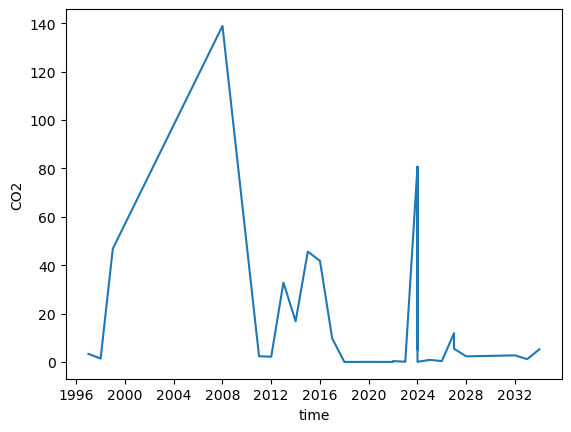

In [20]:
mlca.plot_dynamic_inventory('CO2')

In [21]:
mlca.activity_time_mapping_dict

{(('background_2024', 'C'), 2024): 363,
 (('background_2024', 'electricity_wind'), 2024): 364,
 (('background_2008', 'C'), 2008): 365,
 (('background_2008', 'electricity_wind'), 2008): 366,
 (('foreground', 'E'), 'dynamic'): 367,
 (('foreground', 'D'), 'dynamic'): 368,
 (('foreground', 'B'), 'dynamic'): 369,
 (('foreground', 'A'), 'dynamic'): 370,
 (('background_2024', 'C'), 1997): 371,
 (('background_2024', 'C'), 1998): 372,
 (('background_2024', 'C'), 1999): 373,
 (('foreground', 'B'), 2000): 374,
 (('foreground', 'B'), 2001): 375,
 (('foreground', 'B'), 2002): 376,
 (('foreground', 'B'), 2003): 377,
 (('foreground', 'B'), 2004): 378,
 (('background_2024', 'C'), 2011): 379,
 (('background_2024', 'C'), 2012): 380,
 (('background_2024', 'C'), 2013): 381,
 (('foreground', 'B'), 2014): 382,
 (('background_2024', 'C'), 2014): 383,
 (('foreground', 'B'), 2015): 384,
 (('background_2024', 'C'), 2015): 385,
 (('foreground', 'E'), 2016): 386,
 (('foreground', 'D'), 2016): 387,
 (('foreground'

In [22]:
mlca.biosphere_time_mapping_dict

{('carbon dioxide' (None, None, None),
  numpy.datetime64('2024-01-01T00:00:00')): 0,
 ('carbon dioxide' (None, None, None),
  numpy.datetime64('2008-01-01T00:00:00')): 1,
 ('carbon dioxide' (None, None, None),
  numpy.datetime64('1997-01-01T00:00:00')): 2,
 ('carbon dioxide' (None, None, None),
  numpy.datetime64('1998-01-01T00:00:00')): 3,
 ('carbon dioxide' (None, None, None),
  numpy.datetime64('1999-01-01T00:00:00')): 4,
 ('methane' (None, None, None), numpy.datetime64('1997-12-31T12:21:36')): 5,
 ('methane' (None, None, None), numpy.datetime64('2003-12-31T23:16:48')): 6,
 ('methane' (None, None, None), numpy.datetime64('2005-12-31T10:55:12')): 7,
 ('methane' (None, None, None), numpy.datetime64('1999-01-01T12:21:36')): 8,
 ('methane' (None, None, None), numpy.datetime64('2004-12-31T23:16:48')): 9,
 ('methane' (None, None, None), numpy.datetime64('2007-01-01T10:55:12')): 10,
 ('methane' (None, None, None), numpy.datetime64('2000-01-01T12:21:36')): 11,
 ('methane' (None, None, None

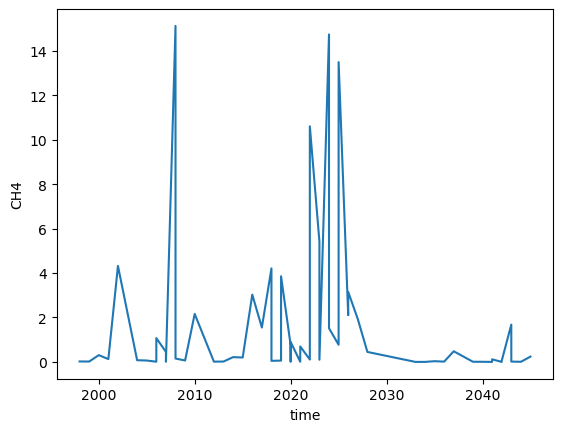

In [23]:
mlca.plot_dynamic_inventory('CH4')

In [24]:
mlca.create_labelled_technosphere_dataframe()

,"((background_2024, C), 2024)","((background_2024, electricity_wind), 2024)","((background_2008, C), 2008)","((background_2008, electricity_wind), 2008)","((foreground, E), dynamic)","((foreground, D), dynamic)","((foreground, B), dynamic)","((foreground, A), dynamic)","((background_2024, C), 1997)","((background_2024, C), 1998)",...,"((background_2024, C), 2027)","((background_2024, C), 2028)","((background_2024, C), 2032)","((background_2024, C), 2033)","((background_2024, C), 2034)","((foreground, B), 2035)","((foreground, B), 2036)","((foreground, B), 2037)","((foreground, B), 2038)","((foreground, B), 2039)"
"((background_2024, C), 2024)",1.0,0.0,0.0,0.0,-11.0,0.0,-13.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0
"((background_2024, electricity_wind), 2024)",-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"((background_2008, C), 2008)",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"((background_2008, electricity_wind), 2008)",0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"((foreground, E), dynamic)",0.0,0.0,0.0,0.0,1.0,-2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"((foreground, B), 2035)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"((foreground, B), 2036)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"((foreground, B), 2037)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"((foreground, B), 2038)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [25]:
mlca.create_labelled_biosphere_dataframe()

,"((background_2024, C), 2024)","((background_2024, electricity_wind), 2024)","((background_2008, C), 2008)","((background_2008, electricity_wind), 2008)","((foreground, E), dynamic)","((foreground, D), dynamic)","((foreground, B), dynamic)","((foreground, A), dynamic)","((background_2024, C), 1997)","((background_2024, C), 1998)",...,"((background_2024, C), 2027)","((background_2024, C), 2028)","((background_2024, C), 2032)","((background_2024, C), 2033)","((background_2024, C), 2034)","((foreground, B), 2035)","((foreground, B), 2036)","((foreground, B), 2037)","((foreground, B), 2038)","((foreground, B), 2039)"
"(temporalis-bio, CO2)",0.0,1.0,0.0,1.0,0.0,0.0,0.0,17.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(temporalis-bio, CH4)",0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,6.0,6.0,6.0,6.0


In [30]:
mlca.create_labelled_dynamic_biosphere_dataframe()

,"((background_2024, C), 2024)","((background_2024, electricity_wind), 2024)","((background_2008, C), 2008)","((background_2008, electricity_wind), 2008)","((foreground, E), dynamic)","((foreground, D), dynamic)","((foreground, B), dynamic)","((foreground, A), dynamic)","((background_2024, C), 1997)","((background_2024, C), 1998)",...,"((background_2024, C), 2027)","((background_2024, C), 2028)","((background_2024, C), 2032)","((background_2024, C), 2033)","((background_2024, C), 2034)","((foreground, B), 2035)","((foreground, B), 2036)","((foreground, B), 2037)","((foreground, B), 2038)","((foreground, B), 2039)"
"(CO2, 2024-01-01T00:00:00)",1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(CO2, 2008-01-01T00:00:00)",0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(CO2, 1997-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(CO2, 1998-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(CO2, 1999-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(CH4, 2041-12-31T23:16:48)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.2,0.0
"(CH4, 2044-01-01T10:55:12)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0
"(CH4, 2036-12-31T12:21:36)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2
"(CH4, 2042-12-31T23:16:48)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.2
